# Selected answers from Networks Problem Sheets 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math 
import scipy.stats
from scipy.linalg import expm
import random 
import scipy
import networkx as nx
from tabulate import tabulate

## PS2 Q1 (d)
##### Illustrate numerically the different regimes of the Erdős-Rényi random graph model (plot something like this).

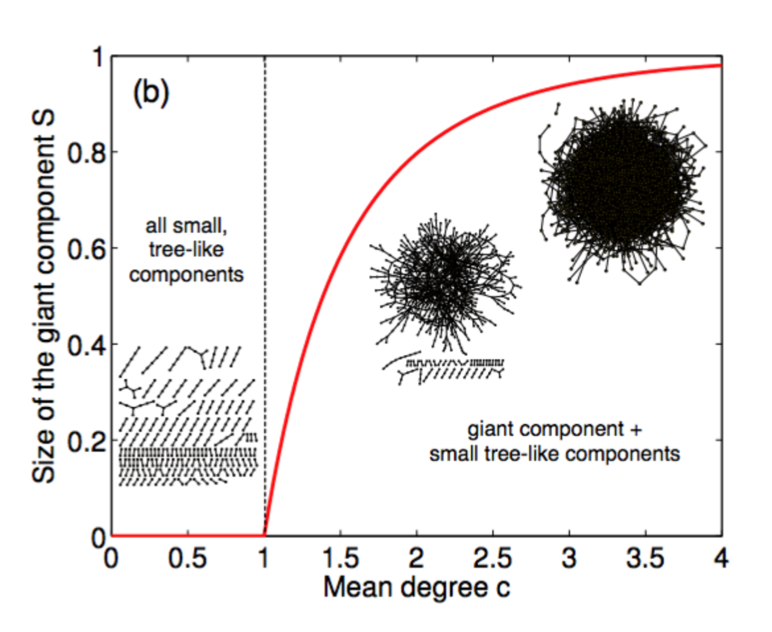

In [2]:
from IPython.display import Image
Image(filename='/Users/willshardlow/Desktop/Screenshot 2021-08-24 at 09.53.08.png', width=400)

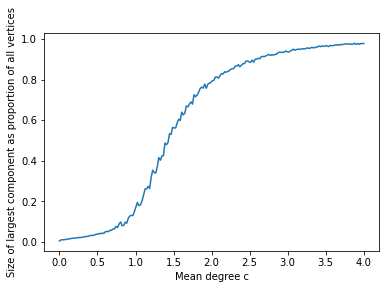

In [3]:
n = 200    # number nodes
r = 200    # number ps
t = 50     # number trials each p

cs = np.linspace(0, 4, r)    #container for the mean degrees c
ps = [x/n for x in cs]       #container for the ps
sizes = np.zeros(r)          #container for the component sizes

for j,p in enumerate(ps):

    A = np.zeros(t)           

    for i in range(t):
        G = nx.binomial_graph(n,p)
        Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
        G0 = G.subgraph(Gcc[0])                                             #extracting the size of the largest connected component
        A[i] = len(G0)

    sizes[j] = np.mean(A)/n
    
plt.plot(cs, sizes)
plt.xlabel("Mean degree c")
plt.ylabel("Size of largest component as proportion of all vertices")

plt.show()

## PS2 Q2 (a)
##### Generate randomised versions of different empirical networks and verify that the number of self-loops and multiple edges becomes negligible when the system is sufficiently large.

I think what this is asking is to take a given, deterministic degree sequence, produce a graph with this degree sequence according to the configuration model, and then see that for large number of vertices, the number of self loops and multiple edges in this graph is small.

Given the filename of an empirical network, func extracts its degree sequence and then produces a random graph with that degree sequence. It then calculates the fraction of edges in the random graph which are self loops / multiple edges and returns this as the second element of a tuple, the first element being the number of nodes in the graph. The table shows that the proportions become smaller as the sizes of the graphs increase.

In [4]:
def func(filename):
    G = nx.read_gml(filename, label = 'id')
    degrees = list(G.degree())
    n = len(degrees)
    deg_seq = np.zeros(n)
    for i in range(n):
        deg_seq[i] = degrees[i][1]     #this creates an array of the degree sequence of the empirical network
    deg_seq = deg_seq.astype(int)

    r = 5                        #number of repeats
    fractions = np.zeros(r)

    for j in range(r):
    
        H = nx.configuration_model(deg_seq)      #creates random graph with given degree sequence

        adj_mx = nx.to_numpy_matrix(H)

        num_selfloops = sum(adj_mx[i,i] for i in range(n))
        np.fill_diagonal(adj_mx,0)                            #this clears the diagonal 
        num_multiedges = np.sum(adj_mx >= 2) / 2

        N = num_multiedges + num_selfloops
        e = H.number_of_edges()
        fraction = N/e                         #fraction of self loops and multiedge out of all edges

        fractions[j] = fraction

    mean = np.mean(fractions)

    return (n,mean)

output_list = [0]*4

output_list[0] = ('Number of nodes', 'Proportion of loops/multiedges')
output_list[1] = func('/Users/willshardlow/Desktop/karate.gml')
output_list[2] = func('/Users/willshardlow/Desktop/dolphins.gml')
output_list[3] = func('/Users/willshardlow/Desktop/power.gml')

print(tabulate(output_list, headers = 'firstrow'))

  Number of nodes    Proportion of loops/multiedges
-----------------  --------------------------------
               34                        0.115385
               62                        0.0666667
             4941                        0.00048529


In the plots below, the white dots show incidences of multiple edges which we cannot even make out in the larger of the two graphs.

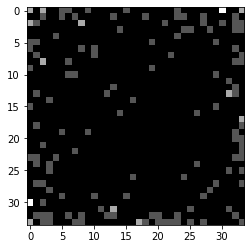

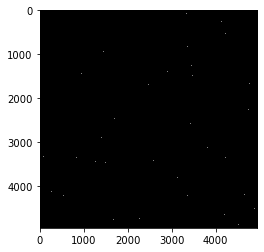

In [5]:
def Visualise(filename):
    
    G = nx.read_gml(filename, label = 'id')
    degrees = list(G.degree())
    n = len(degrees)
    deg_seq = np.zeros(n)

    for i in range(n):
        deg_seq[i] = degrees[i][1]            #this creates an array of the degree sequence of the empirical network
    deg_seq = deg_seq.astype(int)

    H = nx.configuration_model(deg_seq)       #creates random graph with given degree sequence

    adj_mx = nx.to_numpy_matrix(H)

    plt.imshow(adj_mx, interpolation='nearest', cmap='gray')
    plt.show()

Visualise('/Users/willshardlow/Desktop/karate.gml')
Visualise('/Users/willshardlow/Desktop/power.gml')

## Preferential Attachment Model

The following is an implementation of the Barabási-Albert linear preferential attachment model (see https://en.wikipedia.org/wiki/Barabási–Albert_model#Algorithm). It takes as input the number of nodes $n$ and an optional parameter $C$ (a non-negative real number) which can be used to tune the attachment probability. The output is a networkx graph, generated according to preferential attachment.

In [6]:
def pref_att(n, C = 0):

    if type(C) == int:
        C = float(C)
        
    if type(C) != float or C < 0:
        raise Exception("C must be a non-negative real number")     
    
    G = nx.MultiDiGraph()

    G.add_edge(0,0)
    G.add_edge(1,0)                  #creates graph according to first 2 deterministic steps

    for k in range(2,n):

        a = list(G.in_degree())
        l = len(a)
        deg_seq = np.zeros(l)
        for i in range(l):
            deg_seq[i] = a[i][1]

        sum_degrees = sum(deg_seq)
        Z = sum_degrees + l*C                     #normalising const.

        probs = [(C + x) / Z for x in deg_seq]
        cum_probs = np.full(l,probs[0])

        for j in range(1,l):
            cum_probs[j] = probs[j] + cum_probs[j-1]
    
        r = random.random()

        for j in range(l):
            if r < cum_probs[j]:
                y = j
                break
        
        G.add_edge(k,y)     #adds edge according to preferential attachment 
        
    return(G)

## PS3 Q3 (a)
##### Apply modularity optimization techniques implemented in the library of your choice on some examples and visualise the results.

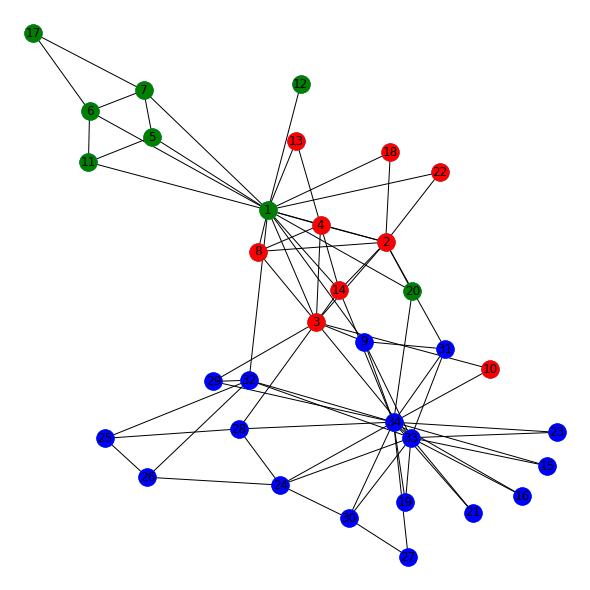

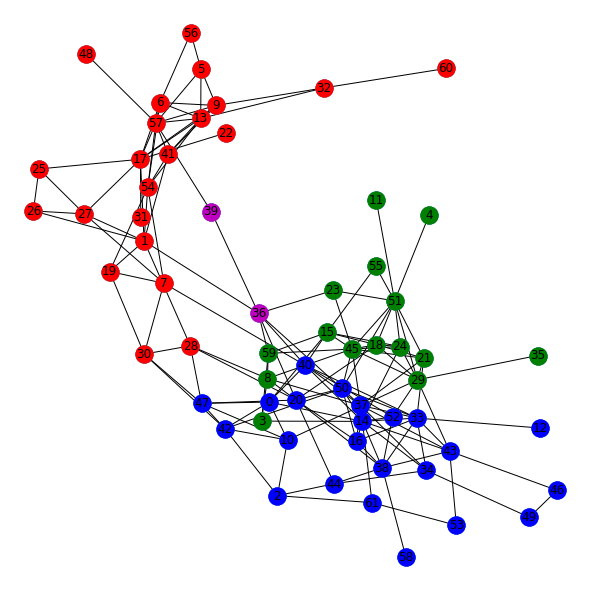

In [7]:
from networkx.algorithms.community import greedy_modularity_communities

def drawCommGraph3 (G, pos = None):
    plt.figure (figsize=(8,8))
    if pos is None:
        pos = nx.spring_layout(G)
    nx.draw(G, pos)
    nx.draw_networkx_labels(G, pos) 
    
    c = list(greedy_modularity_communities(G))
    
    nx.draw_networkx_nodes(G, pos, nodelist=c[0], node_color='b')
    nx.draw_networkx_nodes(G, pos, nodelist=c[1], node_color='r')
    nx.draw_networkx_nodes(G, pos, nodelist=c[2], node_color='g')
    
    plt.show()
    
def drawCommGraph4 (G, pos = None):
    plt.figure (figsize=(8,8))
    if pos is None:
        pos = nx.spring_layout(G)
    nx.draw(G, pos)
    nx.draw_networkx_labels(G, pos) 
    
    c = list(greedy_modularity_communities(G))
    
    nx.draw_networkx_nodes(G, pos, nodelist=c[0], node_color='b')
    nx.draw_networkx_nodes(G, pos, nodelist=c[1], node_color='r')
    nx.draw_networkx_nodes(G, pos, nodelist=c[2], node_color='g')
    nx.draw_networkx_nodes(G, pos, nodelist=c[3], node_color='m')
    
    plt.show()
    
    
G = nx.read_gml('/Users/willshardlow/Desktop/karate.gml', label = 'id')
H = nx.read_gml('/Users/willshardlow/Desktop/dolphins.gml', label = 'id')

drawCommGraph3(G)
drawCommGraph4(H)

## PS4 Q1
##### Write code to simulate consensus dynamics on a network, and plot a figure to show convergence. (Like the one below.)

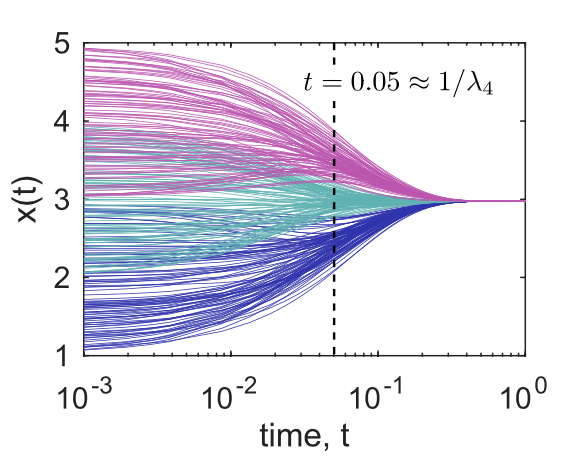

In [8]:
Image(filename='/Users/willshardlow/Desktop/Screenshot 2021-08-24 at 17.23.36.png', width=400)

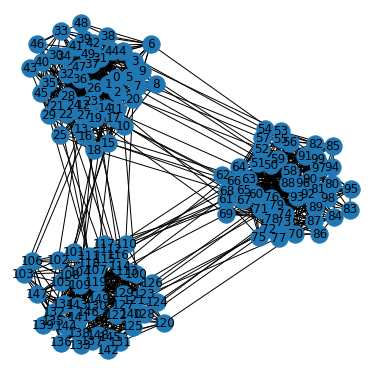

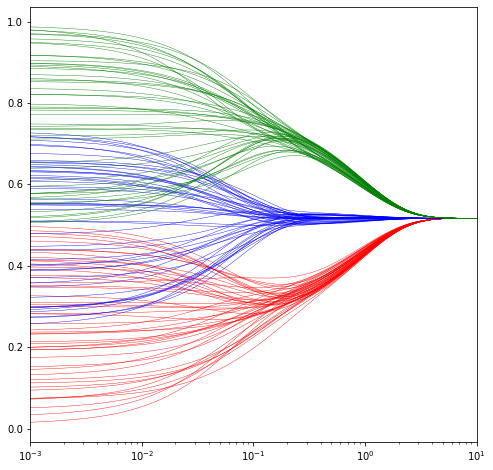

In [9]:
'''We create a graph G with 3 clear communities.'''

G1 = nx.erdos_renyi_graph(50,0.3)
G2 = nx.erdos_renyi_graph(50,0.3)
G3 = nx.erdos_renyi_graph(50,0.3)
G = nx.disjoint_union(G1,G2)
G = nx.disjoint_union(G,G3)

for i in range(20):
    G.add_edge(i,i+50)
    G.add_edge(i+10,i+100)
    G.add_edge(i+60,i+110)
    
plt.figure (figsize=(5,5))
pos = nx.spring_layout(G)
nx.draw(G, pos)
nx.draw_networkx_labels(G, pos) 
plt.show()
    
    
'''Initialise x_0, the vector of starting states of the vertices'''

L = nx.laplacian_matrix(G)
n = G.number_of_nodes()
x_0 = np.random.rand(n,1)
x_0 = [i/2 for i in x_0]

for i in range(50,100):
    x_0[i] = x_0[i] + 0.25
    
for i in range(100,150):
    x_0[i] = x_0[i] + 0.5

ts = np.logspace(-3,1,100)
xs = np.zeros((n,len(ts)))       #container to store the state values of the nodes at each time
L = L.tocsc()

fig = plt.figure(figsize=(8,8))

'''Simulate consensus dynamics according to the solution equation x(t) = exp(-Lt)x_0 '''

for i in range(0,50):
    xs[i] = [expm(-L*t).dot(x_0)[i][0] for t in ts]
    plt.plot(ts,xs[i], color = 'r', linewidth = 0.4)
    
for i in range(50,100):
    xs[i] = [expm(-L*t).dot(x_0)[i][0] for t in ts]
    plt.plot(ts,xs[i], color = 'b', linewidth = 0.4)
    
for i in range(100,150):
    xs[i] = [expm(-L*t).dot(x_0)[i][0] for t in ts]
    plt.plot(ts,xs[i], color = 'g', linewidth = 0.4)

plt.xscale("log")  
plt.xlim(0.001,10)
plt.show()

## PS4 Q2 (b)
##### By performing stochastic simulations of an ensemble of random walkers on a graph, verify numerically Kac’s formula.

For a standard random walk on a graph, Kac's formula is $m_{ii} = \frac{1}{p_i^*}$, where $m_{ii}$ is the mean recurrence time of a vertex $i$ and $p^*$ the stationary distribution.

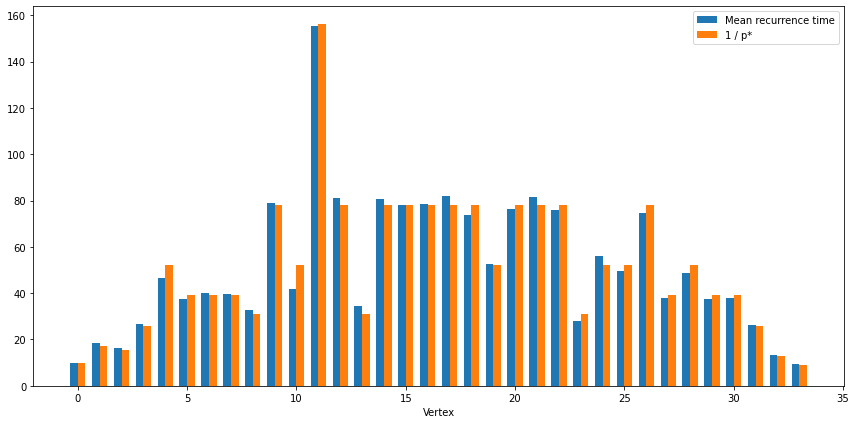

In [10]:
G = nx.karate_club_graph()
n = G.number_of_nodes()
A = nx.linalg.graphmatrix.adjacency_matrix(G)
A = scipy.sparse.csr_matrix.toarray(A)
A = A.astype(float)
D = list(G.degree)
D = [D[i][1] for i in range(n)]
T = np.zeros((n,n))
for i in range(n):
    T[i] = [A[i][j]/D[i] for j in range(n)]         #transition matrix

I = np.identity(n)
Tt = np.transpose(T)
M = Tt - I
pstar = scipy.linalg.null_space(M)                  #solving for stationary distribution pstar
s = sum(pstar)[0]
pstar = [pstar[i][0]/s for i in range(n)]           #normalise
oneoverpstar = [1/pstar[i] for i in range(n)]

n_walkers = 500                                     #number walkers/trials for each node
av_times = [0] * n                                  #container for average return times

for r in range(n):                                  #starting at each vertex

    positions = [r] * n_walkers
    times = [0] * n_walkers


    positions = [np.random.choice(list(range(n)),p=T[r]) for i in range(n_walkers)] #1st step

    for k in range(n_walkers):    
        j=1
        while positions[k] != r and j<1000:
            positions[k] = np.random.choice(list(range(n)),p=T[positions[k]])    #run random walk for each walker
            j +=1
        times[k] = j                               #output return time
    av_times[r] = np.mean(times)                   #mean return time

x = np.arange(n)  
width = 0.35 

fig, ax = plt.subplots(figsize = (12,6))
rects1 = ax.bar(x - width/2, av_times, width, label='Mean recurrence time')
rects2 = ax.bar(x + width/2, oneoverpstar, width, label ='1 / p*')

ax.set_xlabel('Vertex')
ax.legend()

fig.tight_layout()

plt.show()

Our simulations suggest that indeed $m_{ii} = \frac{1}{p_{i}^*}$